In [336]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [337]:
# EEG channels (AUX_1 == EMG)
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']

# Electrodes removed from EEG
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# Eye Tracker channels
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

# Add both channel names to colums for use in DataFrame later
columns =  eye_data_names + channels

# File to use in analysis
path = 'data/LSLData--17-04_samlet/LSLData--17-04-7/'

In [338]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False
  # Loops list of timestamps, if there is a value for old value n, where the new value is n + 1, continue, if not, then
  # The start of the list is the start of the blink, then the last value where n + 1 is valid, is the end of the blink
    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end


"""
Plots single EEG channel
"""
def plot_eeg_single(df,df_ts, column):
    axis = plt.subplot()
    axis.plot(df_ts, df[column])
    axis.set_title(column)
    plt.show()

"""
Plots entire EEG stream, with all channels
"""
def plot_eeg(stream):
    df = pd.DataFrame(stream['time_series'])
    df.columns = columns
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.plot(stream['time_stamps'], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()

"""
Method to apply a zero-phase Butterworth filter to the data
Uses bandpass [0.75-5], and order 4
"""
def zero_phase_butter(data):
    # Filter parameters
    fs = 250
    lowcut =0.75
    highcut = 5.0
    order = 3

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b_bandpass, a_bandpass = signal.butter(order, [low, high], btype="band")

    # Zero-phase filtering using filtfilt
    return signal.filtfilt(b_bandpass, a_bandpass, data)

"""
Return peaks in signal in specified range and normalizes data before finding peak
"""
def get_peaks(df, start, end, column, rang=50, scale=1, order=5, flip=False):
    df = df[start - rang:end + rang]
    # Normalises data
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    # Scales data to and adds plus to make positive for plotting
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y[rang-20:rang+40])
    peaks = [peak + rang-20 for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0
    peak = peaks[np.argmax([y[i] for i in peaks])]+ start - rang

    return  peak if end + rang > peak > start - rang else start



In [339]:
"""
Plots single EEG channel and blinking data for single blink normalized
"""
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    array = np.arange(0,len(df))

    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(array[start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(array[end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(array[start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(array[start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness left - SRanipal")
    axis.plot(array[start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Indexes (1 index equals 4 ms)")
    axis.set_ylabel("Amplitude ")
    axis.set_title("EMG and Eye Tracker data")
    plt.grid(True, linestyle='--', linewidth=0.5, color='0.75')
    ticks = np.arange(start-rang,end + rang, 10)
    plt.xticks(ticks, rotation=90)
    plt.legend()
    plt.show()
"""
Plots single EEG channel and blinking data for single blink
"""
def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    array = np.arange(0,len(df))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(array[start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(array[end], color='red', label = "Blink End - TobiiXR")

    axis.plot(array[start-rang:end+rang], df[column]*(-1 if flip else 1) , label = "EMG")
    axis.set_title("EMG and Eye Tracker data")
    plt.legend()
    plt.show()

"""
PLots entire all EEG channels with blink
"""
def plot_eeg_blink_all(stream, start, end,rang = 50):
    df = pd.DataFrame(stream['time_series'])
    df.columns = columns
    df = df[start - rang:end + rang]
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.axvline(stream['time_stamps'][start], color='red')  # y = 0
        axis.axvline(stream['time_stamps'][end], color='red')
        axis.plot(stream['time_stamps'][start-rang:end+rang], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()

In [340]:

"""
Inits the stream data. Used to get a dataframe with the eye tracking data, and the eeg data for easier data processing
"""
def init_data(data, shift = 0):
    streams = []
    for s in data:
        for t in s:
            streams.append(t)

    #Resample
    resample_ = True
    signal_resampled = streams[1]['time_series']
    df_stream = pd.concat([pd.DataFrame(streams[0]['time_series']), pd.DataFrame(signal_resampled)], axis=1)
    df_stream_ts = pd.DataFrame(streams[0]['time_stamps'])
    df_stream_ts.columns = ['time']
    df_stream.columns = columns
    # Butterworth filter
    df_stream['AUX_1'] = zero_phase_butter(df_stream['AUX_1'])
    # Adds to make sure data is not negative
    df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000
    if shift != 0:
        df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)
    df_stream.dropna(inplace=True)
    df_stream_ts.dropna(inplace=True)
    return streams, df_stream, df_stream_ts

In [341]:
data_eeg, header = pyxdf.load_xdf(path+'/decimated-dejittered-eeg.xdf')
#data_eeg, header = pyxdf.load_xdf(path+'/dejittered-iir-3order-0.75to5-eeg.xdf')
data_eye, header = pyxdf.load_xdf(path+'/dejittered-gaze-and-blinking.xdf')

stream, df_stream, df_stream_ts = init_data([data_eye, data_eeg])
"""
Returns a list of indexes where the user blinked with the left eye, right eye and both eyes
"""
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    #both_blink = df.index[df['both_blink'] == 1].tolist()
    both_blink = df.index[(df['right_openness'] <= 0.1) & (df['left_openness'] <= 0.1)].tolist()
    return left_blinks,right_blinks, both_blink

left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [342]:

avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

[955, 1452, 1919, 2446, 2954, 3462, 3946, 4462, 4959, 5450]
[987, 1485, 1945, 2479, 2992, 3509, 3986, 4500, 5008, 5497]


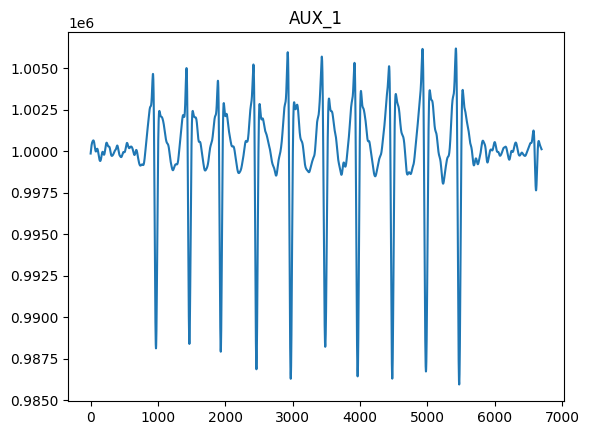

0


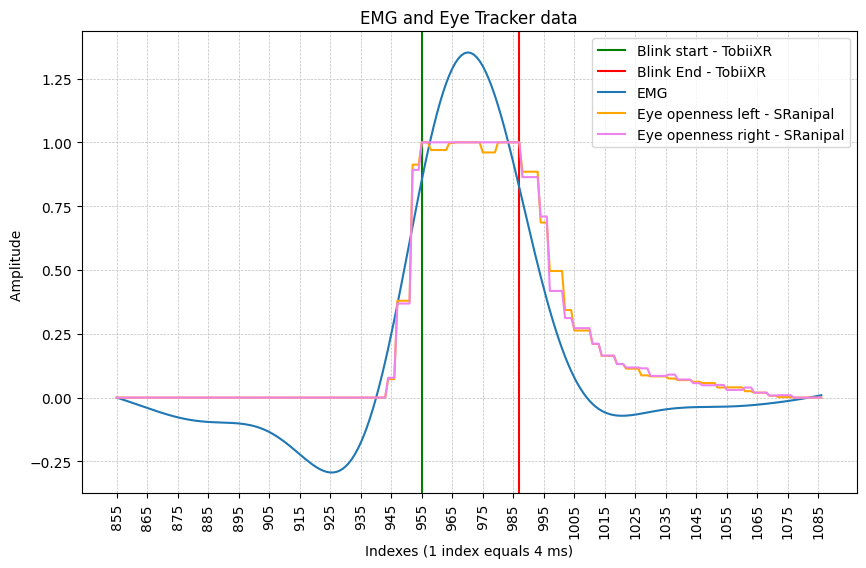

1


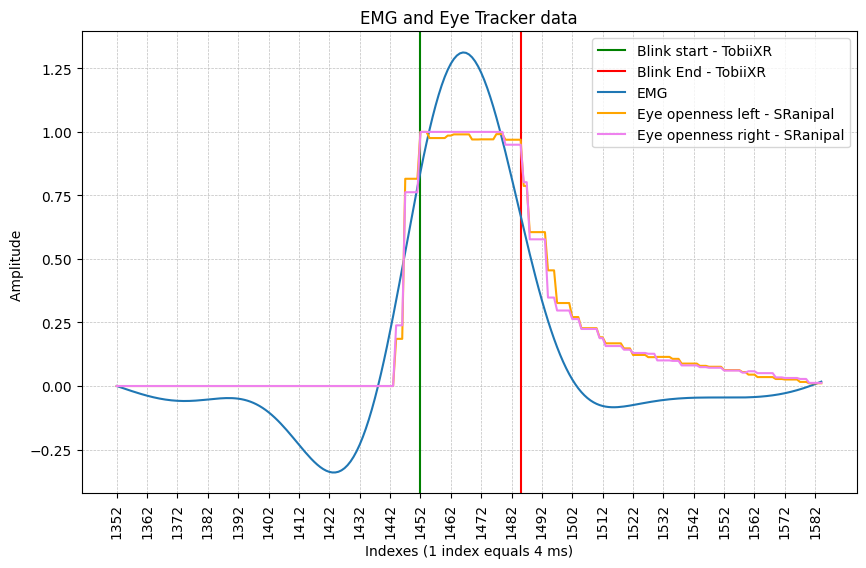

2


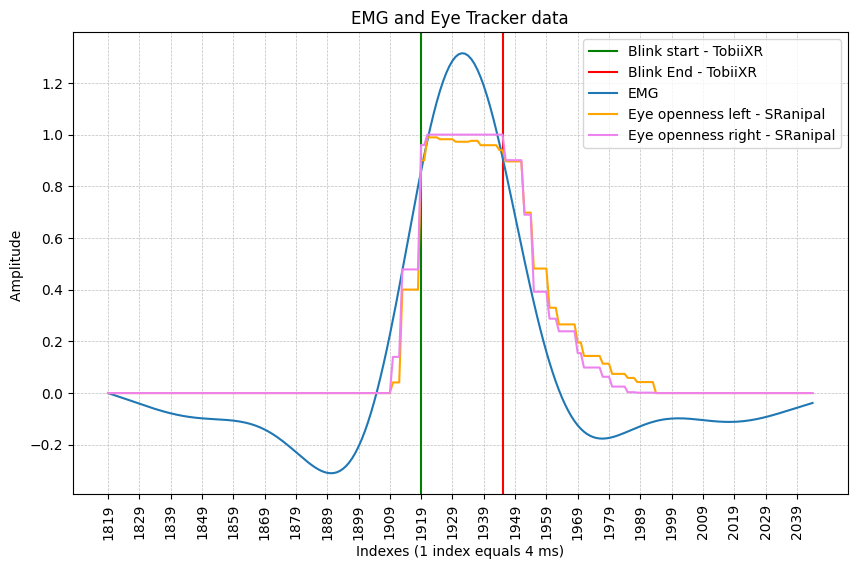

3


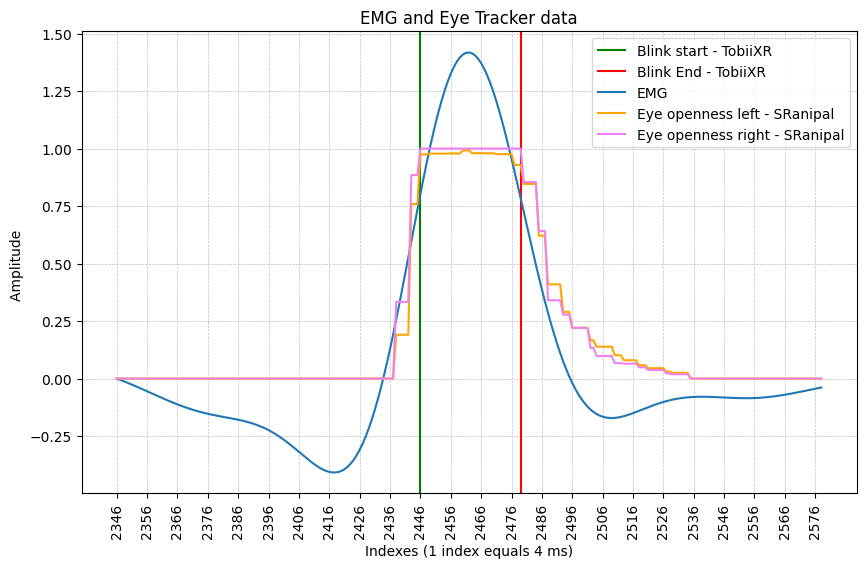

4


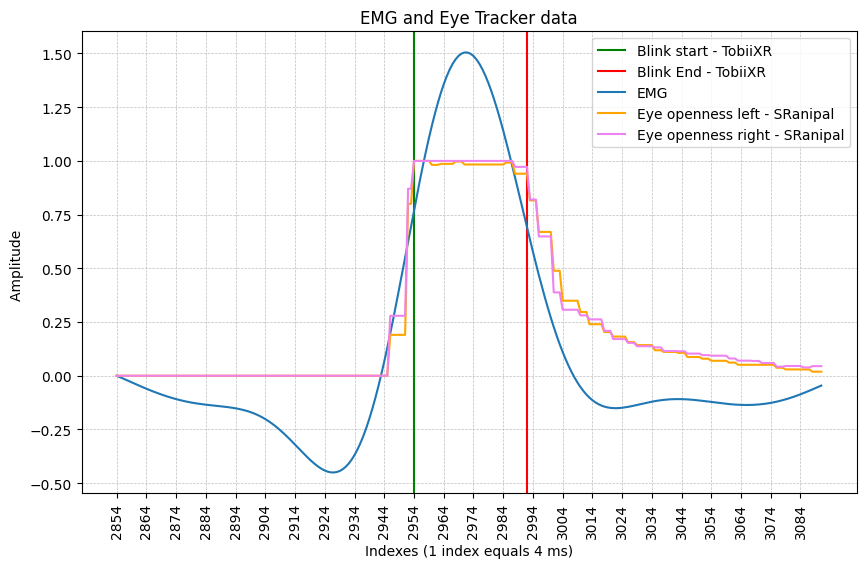

5


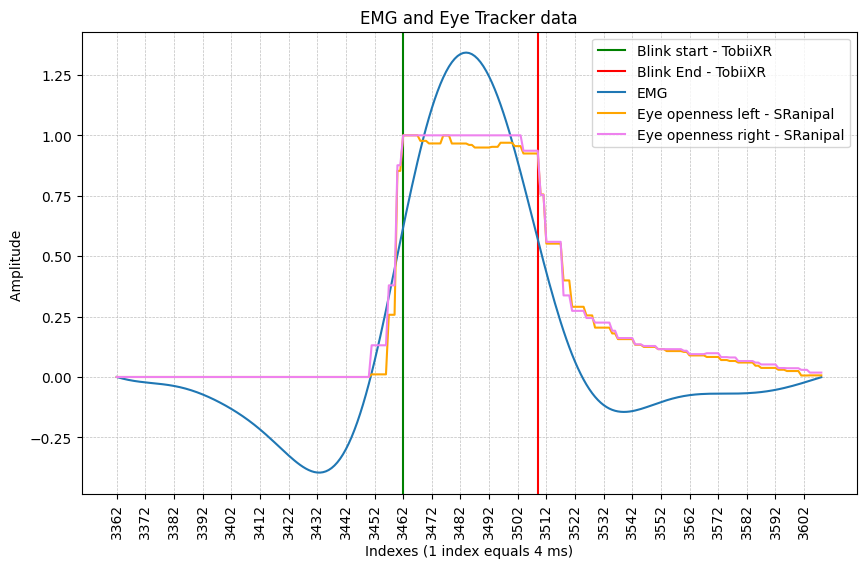

6


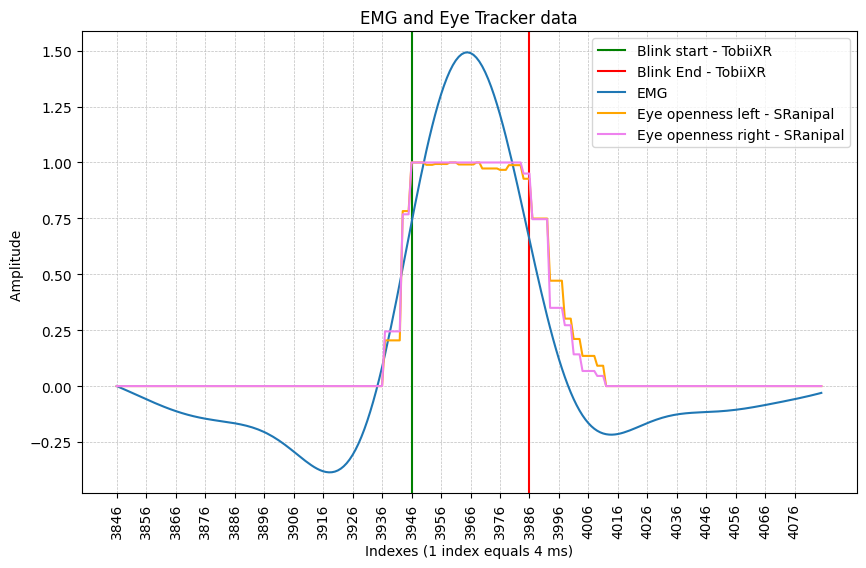

7


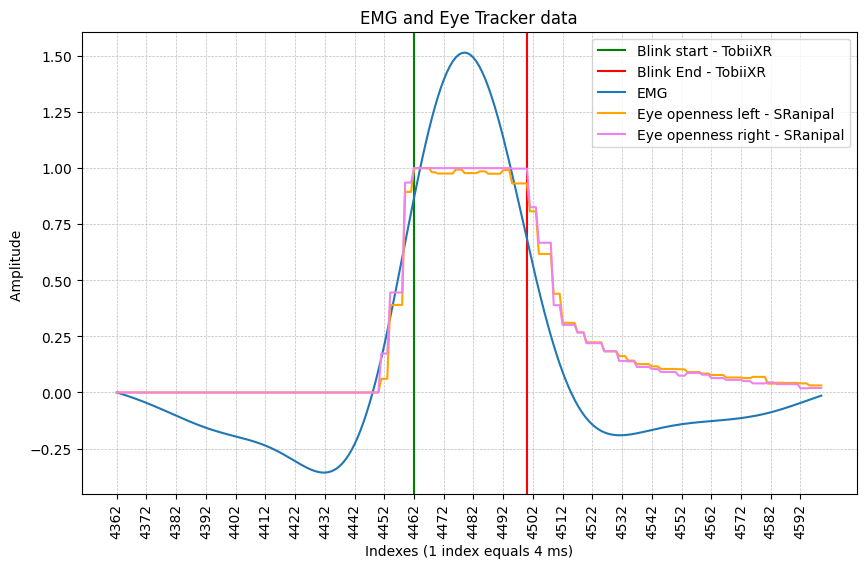

8


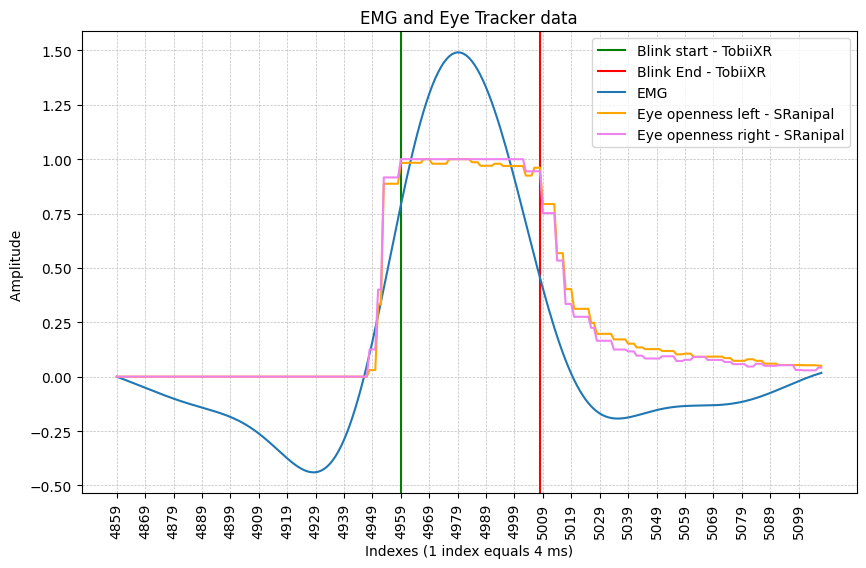

9


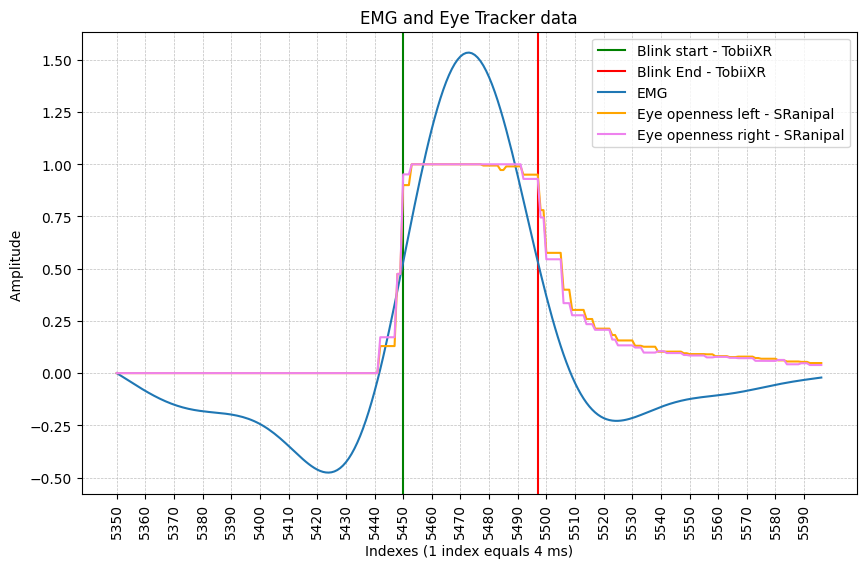

In [343]:
start, end = get_time_stamps(both_blink)

flip = True
chosen_channel = 'AUX_1'
print(start)
print(end)

#df_stream['AUX_1'] = df_stream['AUX_1'] + 100000

plot_eeg_single(df_stream, np.arange(len(df_stream)), chosen_channel)
# Plots all blinks in single recording
for i in range(len(start)):
    print(i)
    plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 100, scale=100, flip=flip)
#plot_eeg_blink_all(stream, start[1], end[1])
#plot_eeg(stream)

In [344]:
from scipy.signal import butter, lfilter


def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    array = np.arange(0,len(df))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(array[start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(array[end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]

    axis.plot(array[start-rang:end+rang], y, label = "EMG")
    axis.plot(array[start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness left - SRanipal")
    axis.plot(array[start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Indexes (1 index equals 4 ms)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(array[i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(round(y[i])) + ", " + str(i+ start - rang))
    axis.set_title("EMG and Eye Tracker data")
    plt.grid(True, linestyle='--', linewidth=0.5, color='0.75')
    ticks = np.arange(start-rang,end + rang, 5)
    plt.xticks(ticks, rotation=90)
    plt.legend()
    plt.show()

    return peaks[np.argmax([y[i] for i in peaks])]+ start - rang ## Get only highest blink onset


"""
If there are multiple peaks in a curve, take the mean point to ensure best accuracy
"""
def find_close_values_mean(values,y, tolerance):
    values.sort()
    peak = values[np.argmax([y[i] for i in values])]
    # Loop list and compare elements
    for i in range(len(values) - 1):
        if abs(values[i] - peak) <= tolerance and values[i] != peak:
            # Return mean if two values are close
            return (values[i] + values[i + 1]) / 2

    return peak

"""
Return peaks in signal in specified range and normalizes data before finding peak
"""
def get_peaks(df, start, end, column, rang=50, scale=1, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0

    peak = find_close_values_mean(peaks, y, 20)+ start - rang
    return  peak

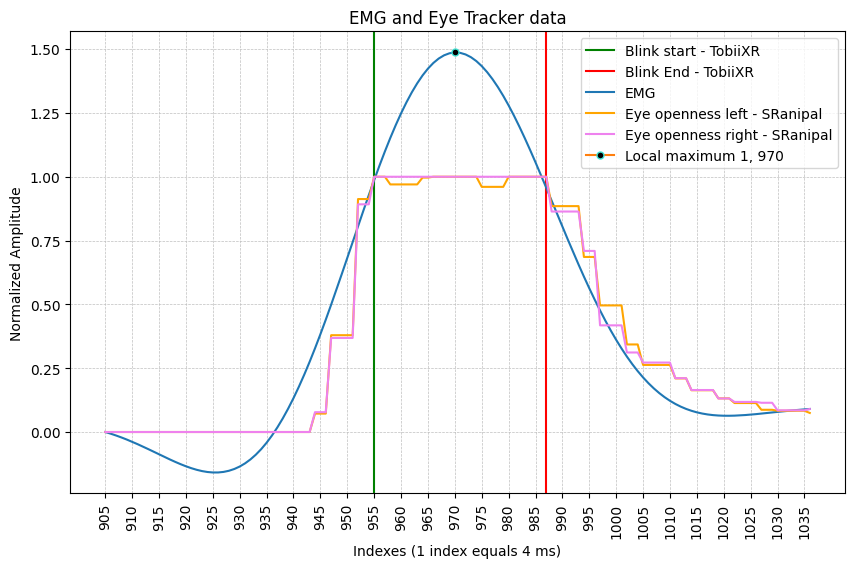

[970]


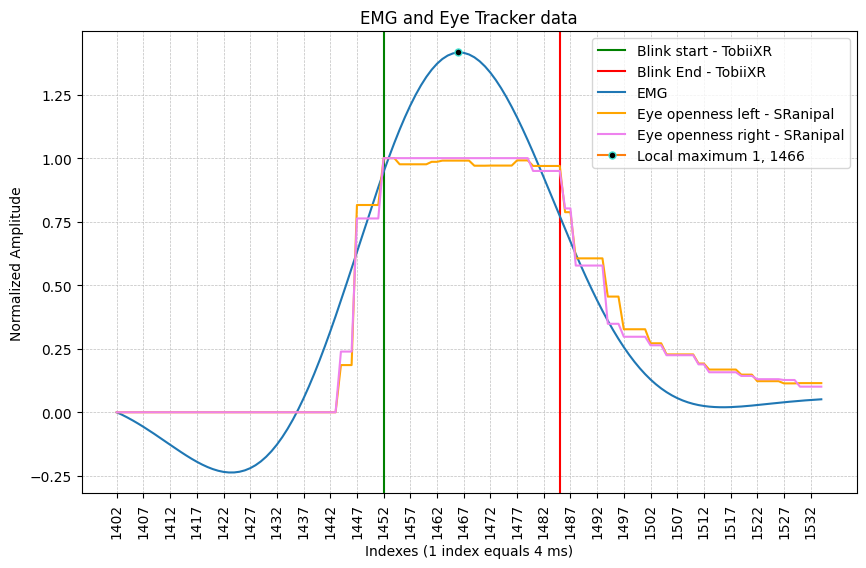

[970, 1466]


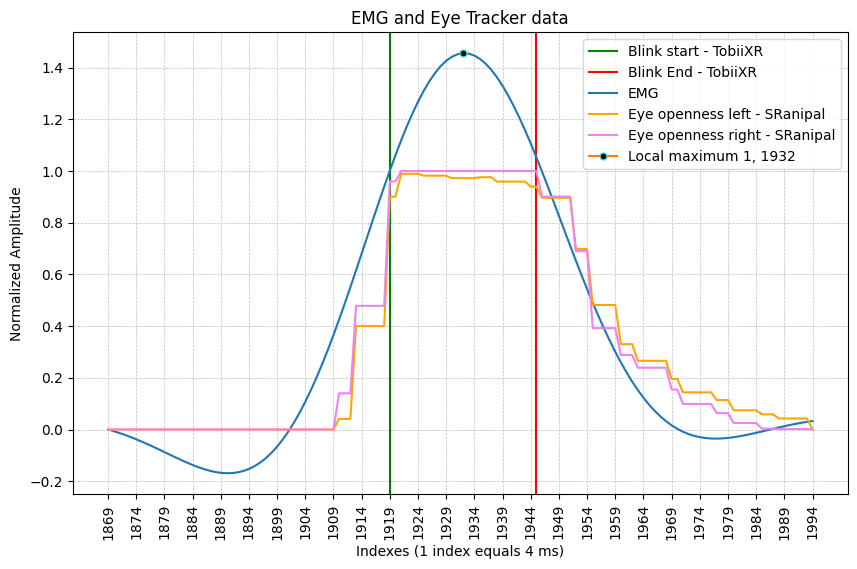

[970, 1466, 1932]


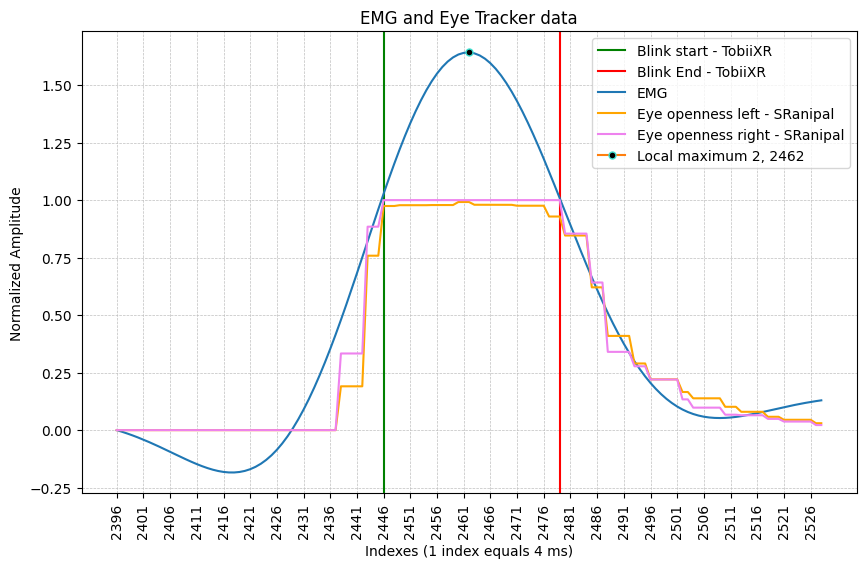

[970, 1466, 1932, 2462]


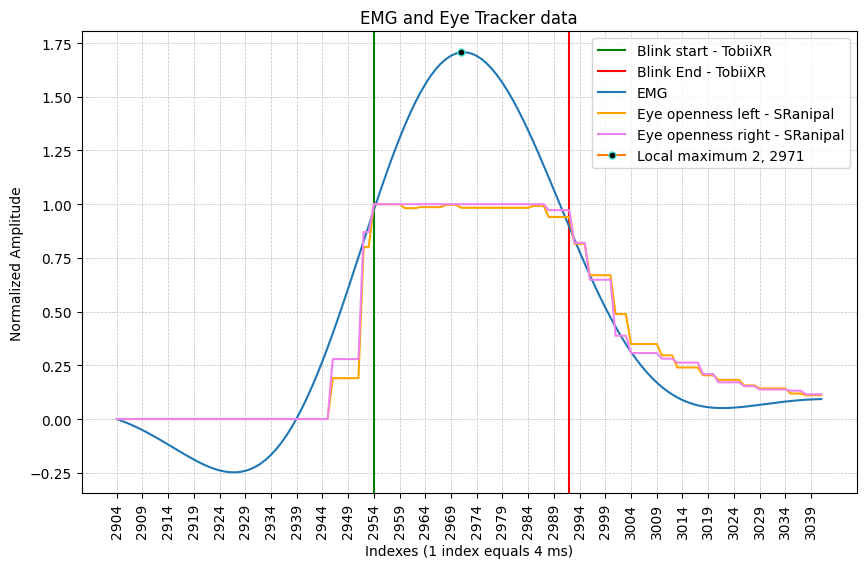

[970, 1466, 1932, 2462, 2971]


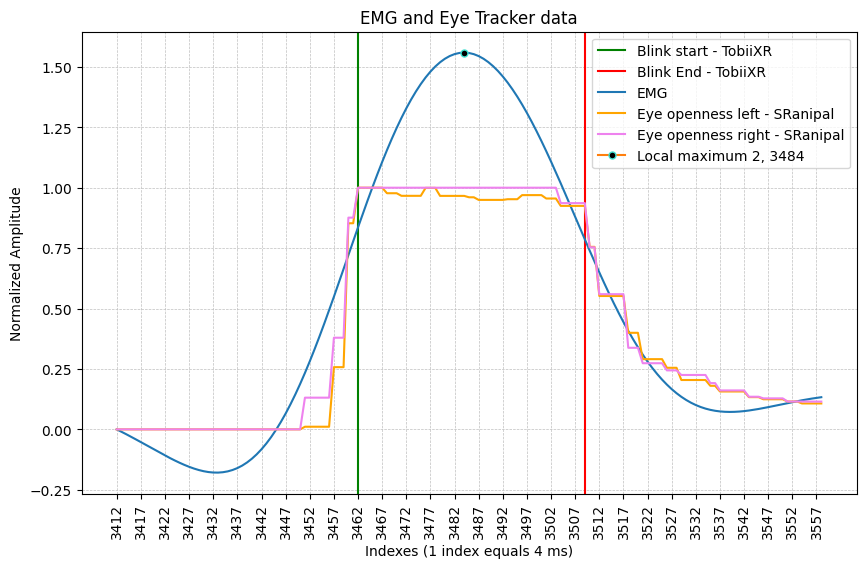

[970, 1466, 1932, 2462, 2971, 3484]


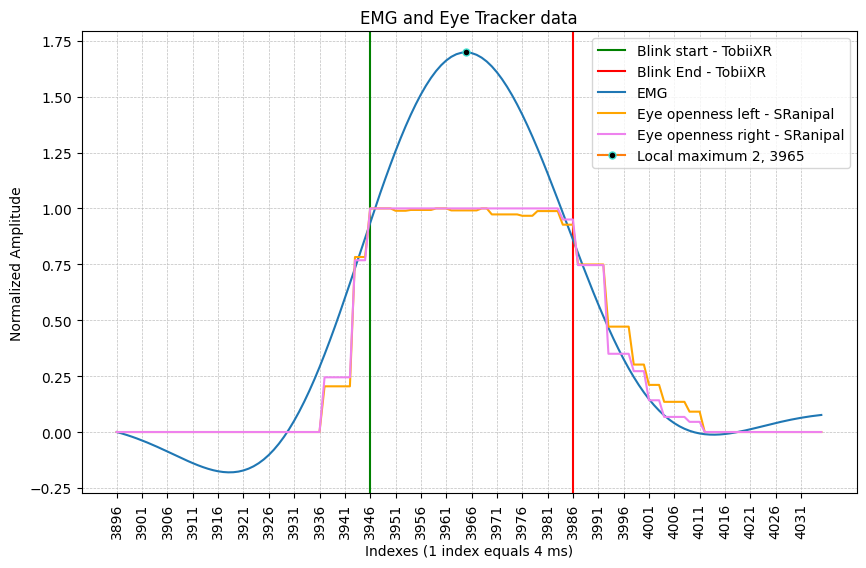

[970, 1466, 1932, 2462, 2971, 3484, 3965]


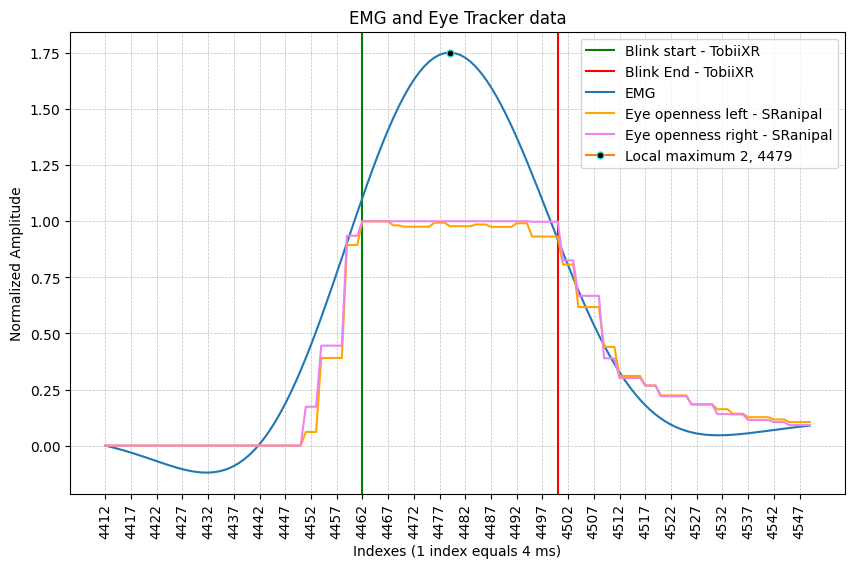

[970, 1466, 1932, 2462, 2971, 3484, 3965, 4479]


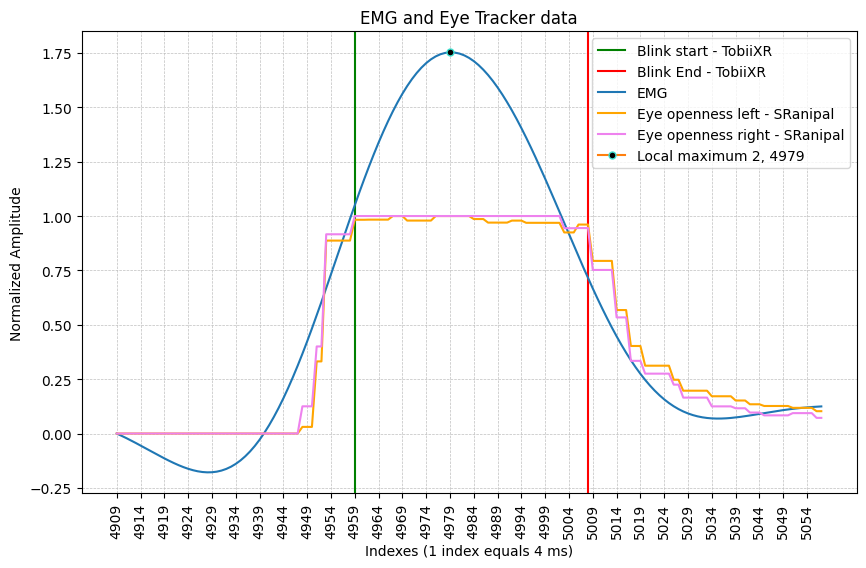

[970, 1466, 1932, 2462, 2971, 3484, 3965, 4479, 4979]


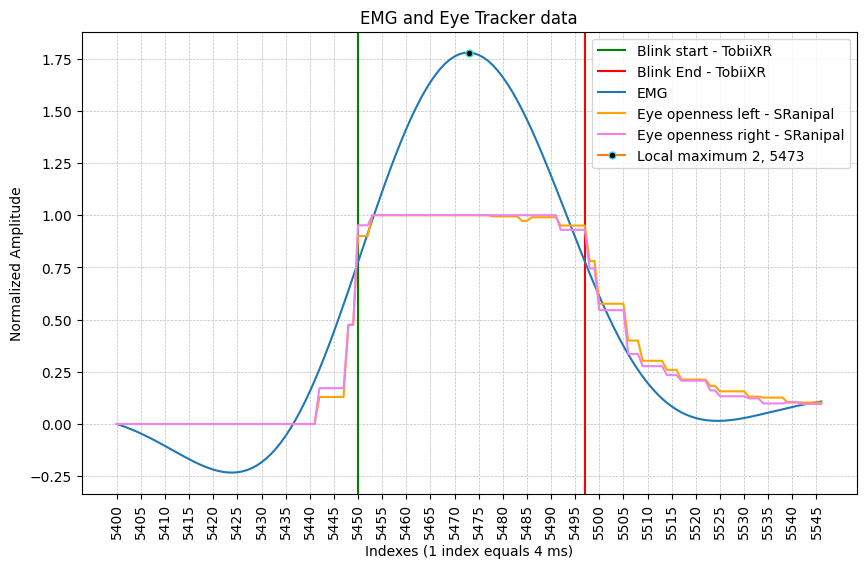

[970, 1466, 1932, 2462, 2971, 3484, 3965, 4479, 4979, 5473]


In [345]:
peaks = []

for i in range(len(start)):
    peaks.append(plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 50, scale=100, flip=flip, order=4))
    print(peaks)

[-15, -14, -13, -16, -17, -22, -19, -17, -20, -23]
-17.6


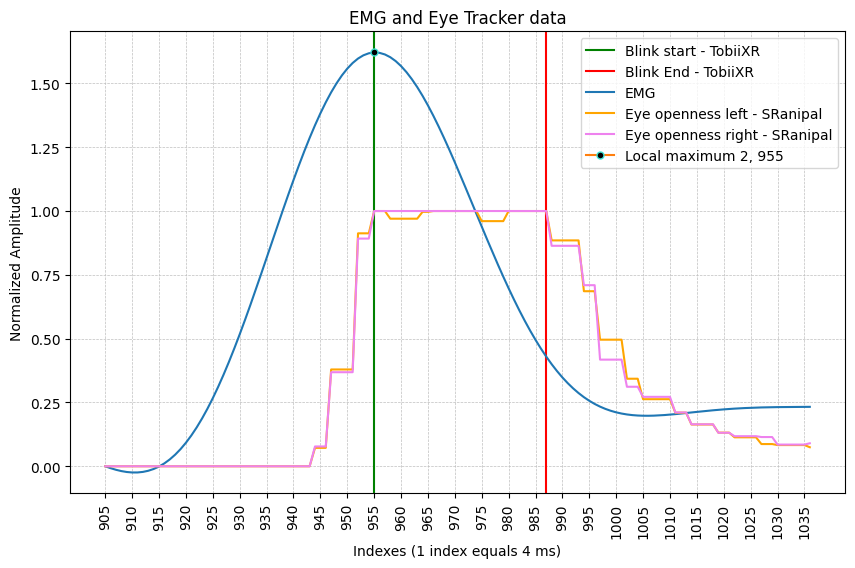

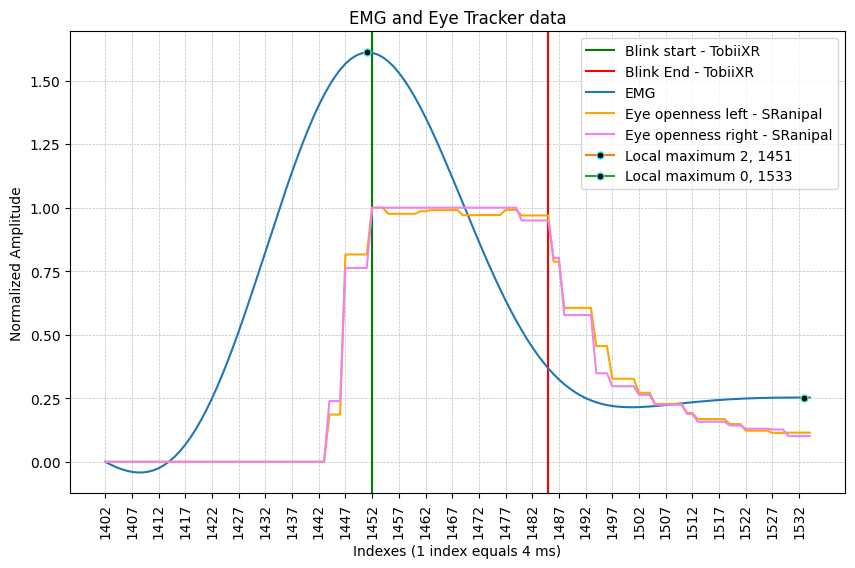

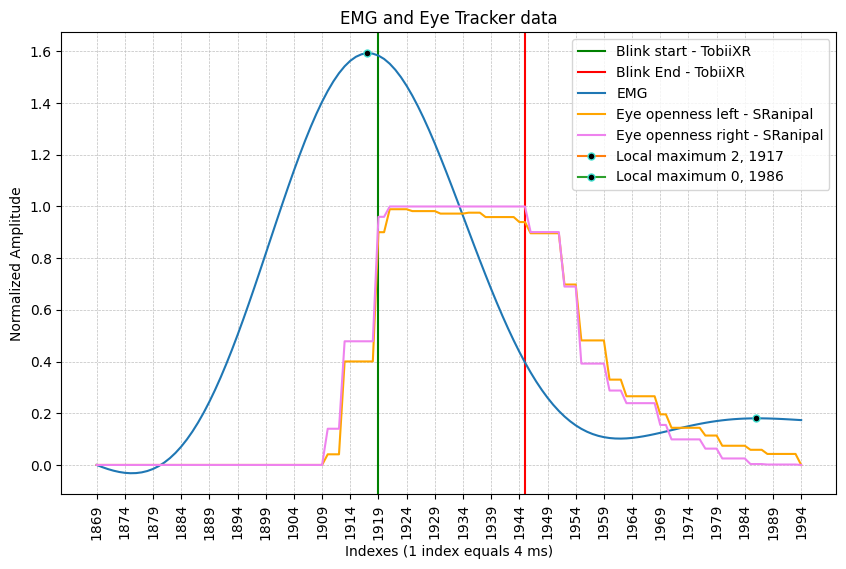

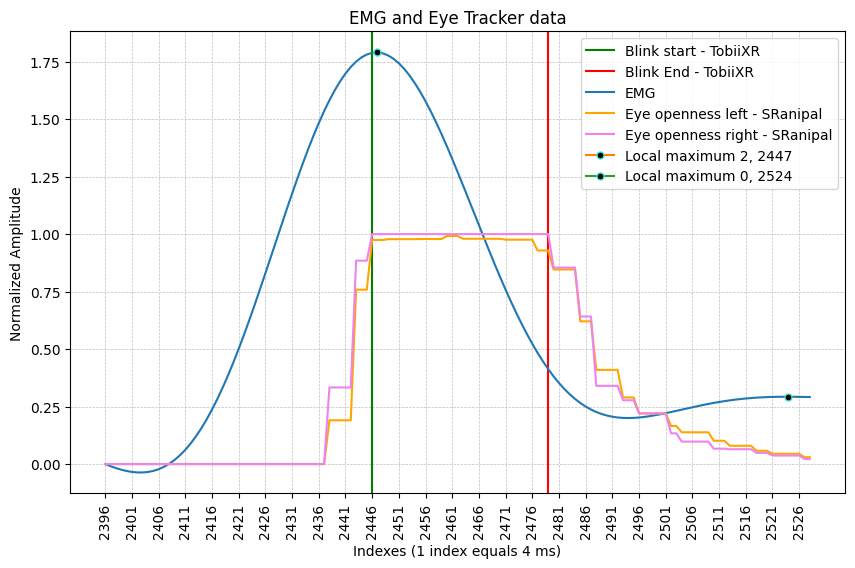

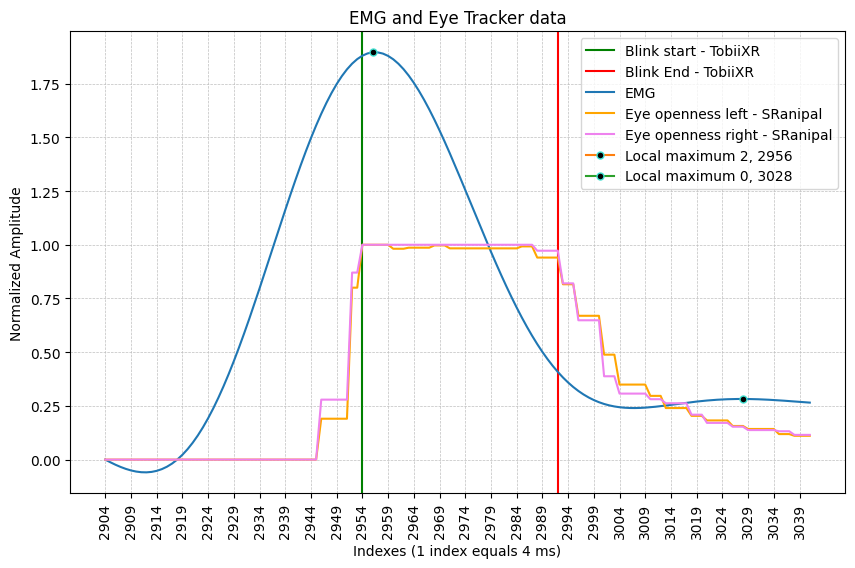

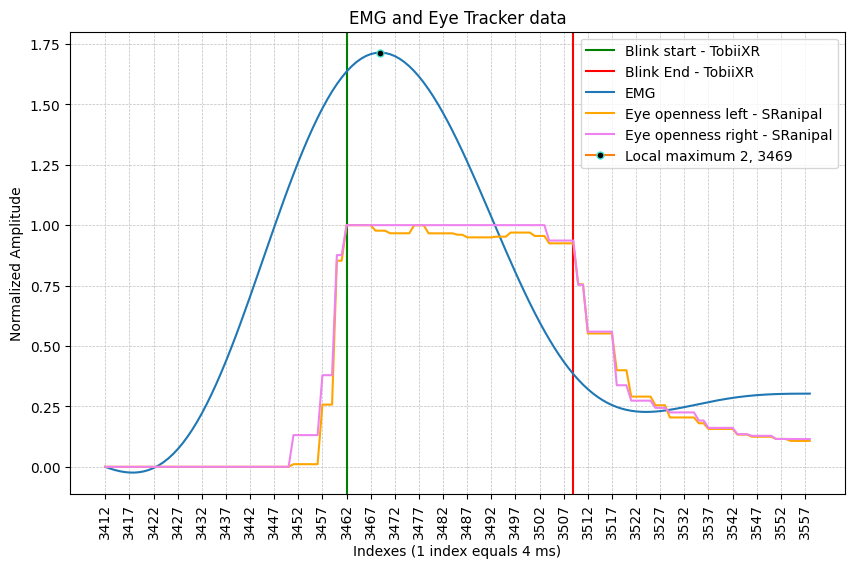

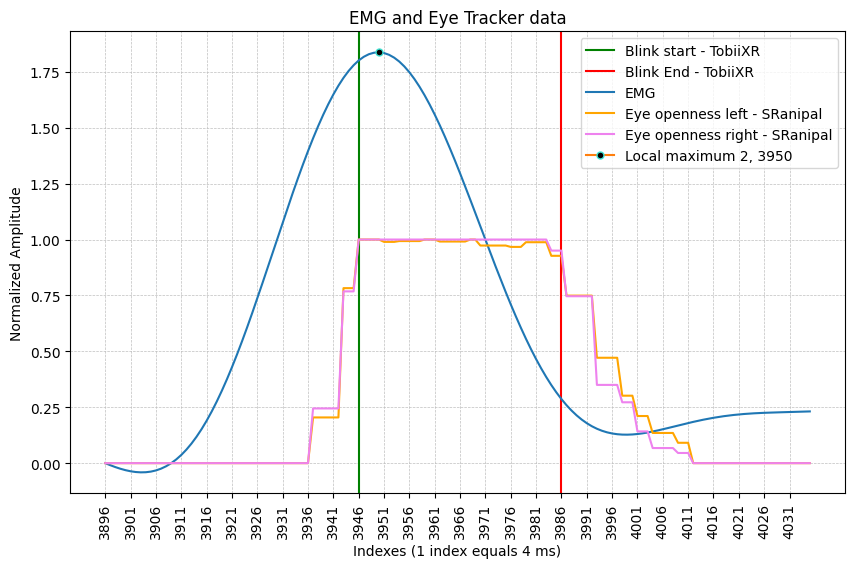

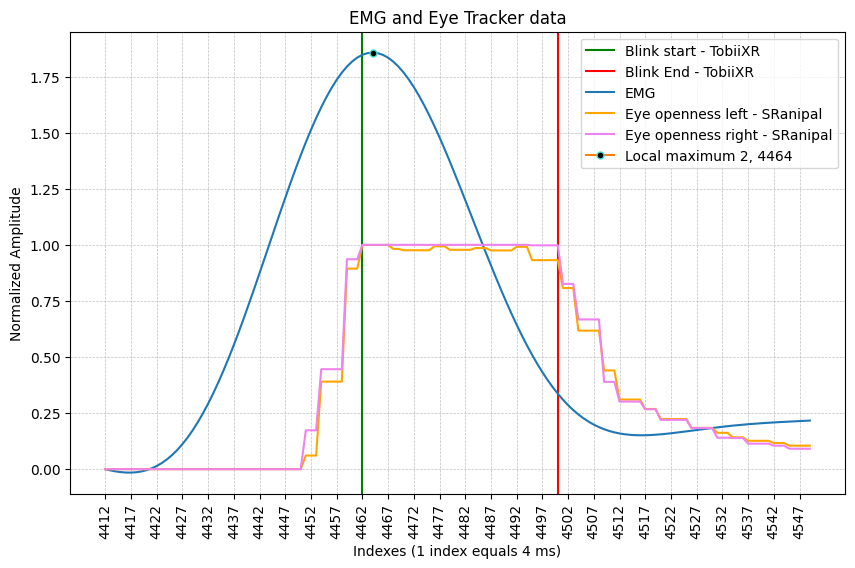

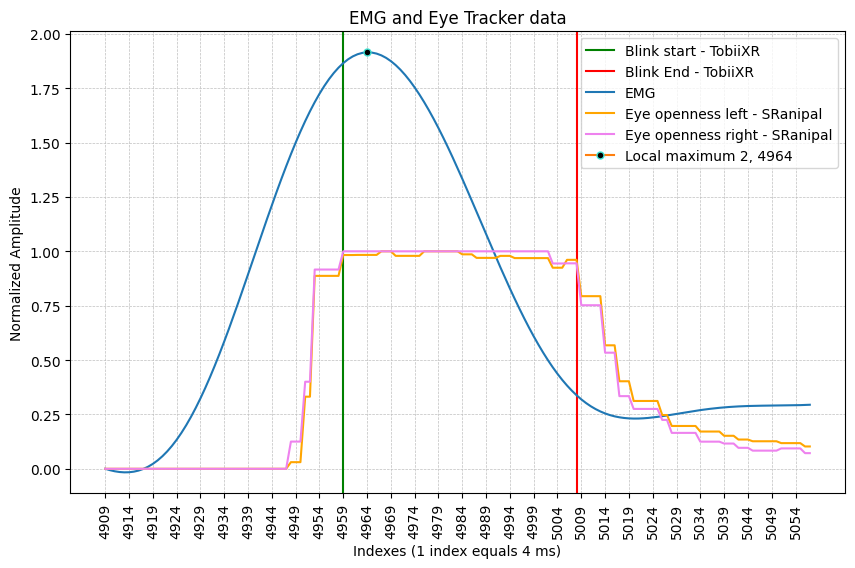

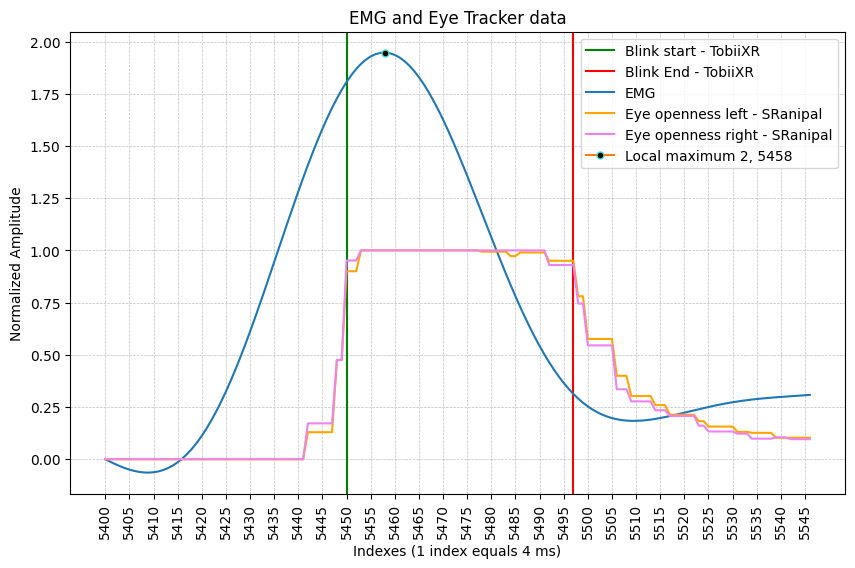

In [346]:
"""
Method to find shifts and returns average length
"""
def find_shift(start, peaks):
    differences_start = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    print(differences_start)
    return sum(differences_start) / len(start)

shift = find_shift(start, peaks)
print(shift)
# Tests if shifts seems correct and prints data
df_stream['AUX_1'] = df_stream['AUX_1'].shift(round((shift)))
for i in range(len(start)):
    plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 50, scale=100, flip=flip, order=4)
